# Assign NK cell annotations

To assemble our annotations, we'll read our clustered Myeloid cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells.

For NK cells, we have two groups of cells to label - Most of the NK cells were assigned labels at one resolution, and the CD56dim cells were assigned labels after additional, iterative clustering. So, we'll load both of these sets, remove iteratively clustered cells from the rest of the NK cells, assign identities based on clusters in each, and finally concatenate all of the cell barcodes.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

### Helper function

This function makes it easy to pull csv files stored in HISE as a pandas data.frame

In [2]:
def read_csv_uuid(csv_uuid):
    csv_path = '/home/jupyter/cache/{u}'.format(u = csv_uuid)
    if not os.path.isdir(csv_path):
        hise_res = hisepy.reader.cache_files([csv_uuid])
    csv_filename = os.listdir(csv_path)[0]
    csv_file = '{p}/{f}'.format(p = csv_path, f = csv_filename)
    df = pd.read_csv(csv_file, index_col = 0)
    return df

## Read subclustering results from HISE

In [3]:
cell_class = 'nk-cells'

In [4]:
h5ad_uuid = 'b2a3d1ba-312d-41ec-9e51-8ef4c33192fe'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [5]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [6]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [7]:
adata = sc.read_h5ad(h5ad_file)

In [8]:
adata.shape

(160848, 1357)

## Read CD56dim subclustering results from HISE

In [9]:
dim_uuid = '9b961a21-482c-44a6-ab08-823ed33257a4'
dim_path = '/home/jupyter/cache/{u}'.format(u = dim_uuid)

In [10]:
if not os.path.isdir(dim_path):
    hise_res = hisepy.reader.cache_files([dim_path])

In [11]:
dim_filename = os.listdir(dim_path)[0]
dim_file = '{p}/{f}'.format(p = dim_path, f = dim_filename)

In [12]:
dim_adata = sc.read_h5ad(dim_file)

In [13]:
dim_adata.shape

(105676, 1587)

## Subset non-CD56dim cells

In [14]:
drop_lgl = [not x for x in adata.obs['barcodes'].isin(dim_adata.obs['barcodes'])]

In [15]:
nondim_adata = adata[drop_lgl].copy()

In [16]:
nondim_adata.shape

(55172, 1357)

## Read non-dim annotations

In [17]:
anno_uuid = 'f4170e78-2989-4a86-b256-3360b7561e44'

In [18]:
anno = read_csv_uuid(anno_uuid)

## Assign non-dim labels

In [19]:
join_col = 'leiden_resolution_1.5'

In [20]:
anno[join_col] = anno[join_col].astype('string').astype('category')

In [21]:
obs = nondim_adata.obs

In [22]:
sum(obs[join_col].isin(anno[join_col]))

55172

In [23]:
nondim_anno = obs.merge(anno, how = 'left', on = join_col)

In [24]:
nondim_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,AIFI_L3,AIFI_L1,AIFI_L2
0,cf72d2f048b611ea8957bafe6d70929e,B001,shrewd_chocolaty_xrayfish,cf72d2f048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1229,51,8644,...,51,3.951244,1.943598,4,3,3,3,GZMK+ CD56dim NK cell,NK cell,CD56dim NK cell
1,cf73d29048b611ea8957bafe6d70929e,B001,subocean_bold_oriole,cf73d29048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2005,246,18676,...,246,5.509388,4.392073,4,8,11,13,NK+T Doublets,NK cell,NK+T Doublets
2,cf7577c648b611ea8957bafe6d70929e,B001,purply_religious_gelada,cf7577c648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1374,221,10388,...,221,5.402677,7.031499,4,7,6,6,Adaptive NK cell,NK cell,CD56dim NK cell
3,cf774a9c48b611ea8957bafe6d70929e,B001,cleverish_landpoor_tadpole,cf774a9c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1848,69,16561,...,69,4.248495,1.351881,4,8,11,13,NK+T Doublets,NK cell,NK+T Doublets
4,cf7a833848b611ea8957bafe6d70929e,B001,inartistic_abusive_turtledove,cf7a833848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1197,138,8657,...,138,4.934474,5.369650,4,7,6,6,Adaptive NK cell,NK cell,CD56dim NK cell


## Read CD56dim annotations

In [25]:
dim_anno_uuid = '2fa8b5bf-0759-4604-b4f5-e71e78c1a324'
dim_anno = read_csv_uuid(dim_anno_uuid)

## Assign memory labels

In [26]:
join_col = 'leiden_resolution_1.5_nk-cells-dim'

In [27]:
dim_anno[join_col] = dim_anno[join_col].astype('string').astype('category')

In [28]:
obs = dim_adata.obs

In [29]:
sum(obs[join_col].isin(dim_anno[join_col]))

105676

In [30]:
dim_anno = obs.merge(dim_anno, how = 'left', on = join_col)

In [31]:
dim_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,leiden_resolution_1.5_nk-cells-dim,AIFI_L3,AIFI_L1,AIFI_L2
0,cf73ecda48b611ea8957bafe6d70929e,B001,observant_fathomable_barracuda,cf73ecda48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,921,37,5216,...,3.637586,2.355188,4,1,1,0,2,GZMK- CD56dim NK cell,NK cell,CD56dim NK cell
1,cf7430b448b611ea8957bafe6d70929e,B001,omniscient_slim_hoki,cf7430b448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2153,117,16241,...,4.770685,2.358395,4,0,0,1,3,GZMK- CD56dim NK cell,NK cell,CD56dim NK cell
2,cf754e0448b611ea8957bafe6d70929e,B001,glossy_intimate_ladybug,cf754e0448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1497,131,9952,...,4.882802,4.069587,4,12,15,18,10,GZMK- CD56dim NK cell,NK cell,CD56dim NK cell
3,cf7802de48b611ea8957bafe6d70929e,B001,illbred_mobile_sable,cf7802de48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1535,172,10832,...,5.153292,4.992743,4,4,4,18,7,GZMK- CD56dim NK cell,NK cell,CD56dim NK cell
4,cf7ab2a448b611ea8957bafe6d70929e,B001,dishonest_virile_beauceron,cf7ab2a448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1528,46,10767,...,3.850148,1.396055,4,2,10,9,8,GZMK- CD56dim NK cell,NK cell,CD56dim NK cell


## Concatenate annotations

In [32]:
anno = pd.concat([nondim_anno, dim_anno], axis = 0)

In [33]:
anno = anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

## Add to AnnData to preview assignments

In [34]:
anno = anno.set_index('barcodes')

In [35]:
obs = adata.obs
obs = obs.merge(anno, how = 'left', left_index = True, right_index = True)

In [36]:
adata.obs = obs

In [37]:
adata.obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,AIFI_L1,AIFI_L2,AIFI_L3
barcodes,,,,,,,,,,,,,,,,,,,,,
cf72d2f048b611ea8957bafe6d70929e,cf72d2f048b611ea8957bafe6d70929e,B001,shrewd_chocolaty_xrayfish,cf72d2f048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1229,51,8644,...,51,3.951244,1.943598,4,3,3,3,NK cell,CD56dim NK cell,GZMK+ CD56dim NK cell
cf73d29048b611ea8957bafe6d70929e,cf73d29048b611ea8957bafe6d70929e,B001,subocean_bold_oriole,cf73d29048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2005,246,18676,...,246,5.509388,4.392073,4,8,11,13,NK cell,NK+T Doublets,NK+T Doublets
cf73ecda48b611ea8957bafe6d70929e,cf73ecda48b611ea8957bafe6d70929e,B001,observant_fathomable_barracuda,cf73ecda48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,921,37,5216,...,37,3.637586,2.355188,4,1,1,0,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell
cf7430b448b611ea8957bafe6d70929e,cf7430b448b611ea8957bafe6d70929e,B001,omniscient_slim_hoki,cf7430b448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2153,117,16241,...,117,4.770685,2.358395,4,0,0,1,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell
cf754e0448b611ea8957bafe6d70929e,cf754e0448b611ea8957bafe6d70929e,B001,glossy_intimate_ladybug,cf754e0448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1497,131,9952,...,131,4.882802,4.069587,4,12,15,18,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


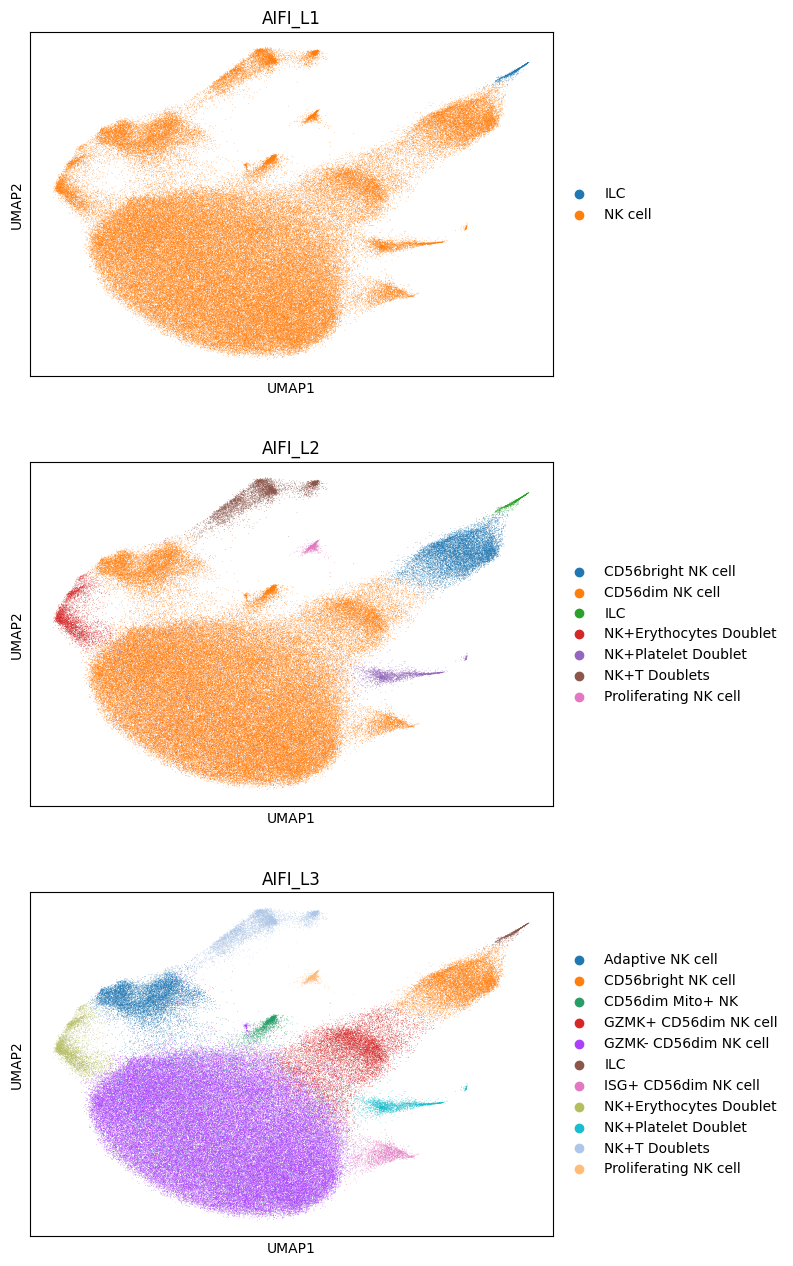

In [38]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


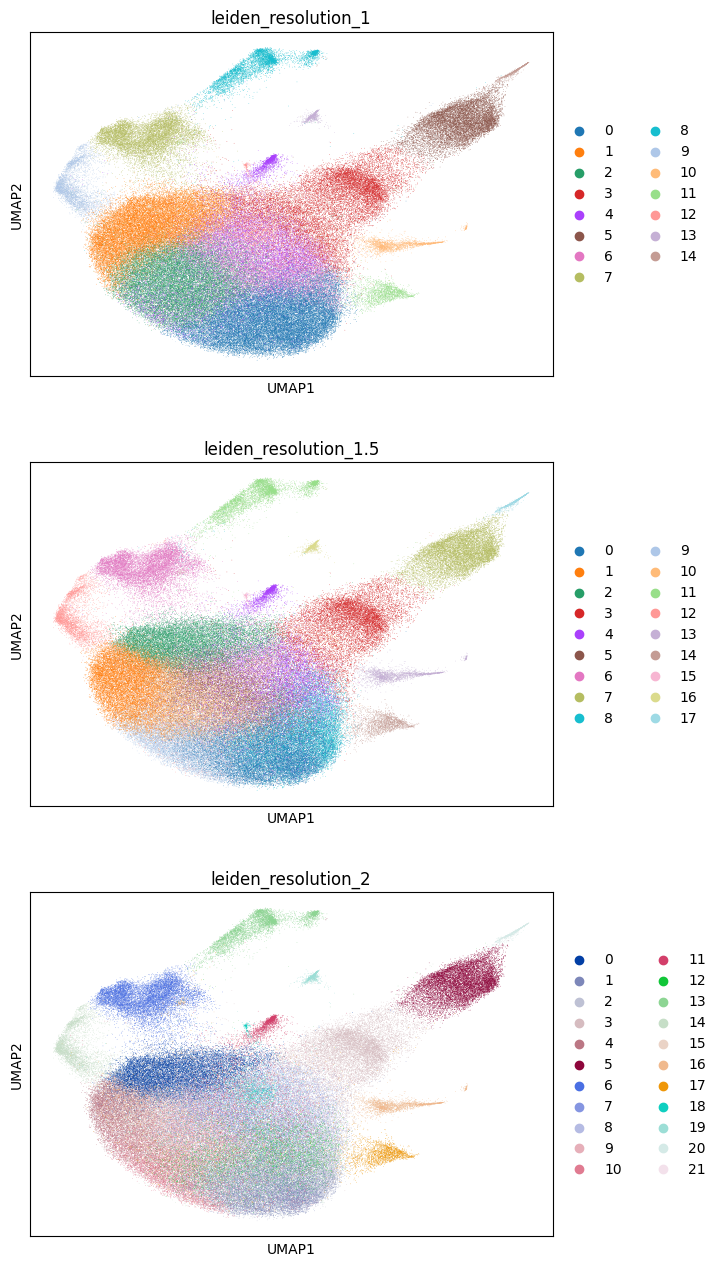

In [39]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2'],
           ncols = 1)

## Output final annotations

In [40]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [41]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [42]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,AIFI_L1,AIFI_L2,AIFI_L3,umap_1,umap_2
0,cf72d2f048b611ea8957bafe6d70929e,B001,shrewd_chocolaty_xrayfish,cf72d2f048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1229,51,8644,...,1.943598,4,3,3,3,NK cell,CD56dim NK cell,GZMK+ CD56dim NK cell,0.883505,7.876848
1,cf73d29048b611ea8957bafe6d70929e,B001,subocean_bold_oriole,cf73d29048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2005,246,18676,...,4.392073,4,8,11,13,NK cell,NK+T Doublets,NK+T Doublets,-0.265153,12.770269
2,cf73ecda48b611ea8957bafe6d70929e,B001,observant_fathomable_barracuda,cf73ecda48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,921,37,5216,...,2.355188,4,1,1,0,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell,-2.538007,7.109251
3,cf7430b448b611ea8957bafe6d70929e,B001,omniscient_slim_hoki,cf7430b448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,2153,117,16241,...,2.358395,4,0,0,1,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell,-0.433553,3.528103
4,cf754e0448b611ea8957bafe6d70929e,B001,glossy_intimate_ladybug,cf754e0448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1497,131,9952,...,4.069587,4,12,15,18,NK cell,CD56dim NK cell,GZMK- CD56dim NK cell,0.191648,5.767444


In [43]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [44]:
obs_out_csv = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [45]:
obs_out_parquet = '{p}/ref_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [46]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [47]:
label_out_csv = '{p}/ref_pbmc_{c}_barcode_labels_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [48]:
label_out_parquet = '{p}/ref_pbmc_{c}_barcode_labels_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [49]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Myeloid cell barcode annotations {d}'.format(d = date.today())

In [50]:
in_files = [h5ad_uuid, dim_uuid, anno_uuid, dim_anno_uuid]

In [51]:
in_files

['b2a3d1ba-312d-41ec-9e51-8ef4c33192fe',
 '9b961a21-482c-44a6-ab08-823ed33257a4',
 'f4170e78-2989-4a86-b256-3360b7561e44',
 '2fa8b5bf-0759-4604-b4f5-e71e78c1a324']

In [52]:
out_files = [obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [53]:
out_files

['output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.csv',
 'output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.parquet',
 'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.csv',
 'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.parquet']

In [54]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.csv
output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.parquet
output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.csv
output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.parquet
Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/19-Python_assign_NK_cells.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/19-Python_assign_NK_cells_old.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/22-Python_assemble_final_labels.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.csv', 'output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.parquet', 'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.csv', 'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': '15567d10-d160-42e5-a75a-c663c8ec8cd6',
 'files': ['output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.csv',
  'output/ref_pbmc_nk-cells_labeled_meta_umap_2024-03-05.parquet',
  'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.csv',
  'output/ref_pbmc_nk-cells_barcode_labels_2024-03-05.parquet']}

In [55]:
import session_info
session_info.show()